In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

In [3]:
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "2g")
    .config("spark.executor.memory", "4g")
    .getOrCreate()
)

In [4]:
# For feature selection
sdf_data = spark.read.parquet('../data/curated/result/')
sdf_data.limit(5)

Date,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,fare,trip_type,shift,Day,temp
2021-08-01,2021-08-01 00:36:25,2021-08-01 00:43:35,N,1.0,41,74,1.0,7.8,1.0,Night,Sun,71
2021-08-01,2021-08-01 00:47:18,2021-08-01 00:50:48,N,1.0,41,74,1.0,6.3,1.0,Night,Sun,71
2021-08-01,2021-08-01 00:08:34,2021-08-01 00:12:09,N,1.0,95,95,2.0,6.3,1.0,Night,Sun,71
2021-08-01,2021-08-01 00:05:32,2021-08-01 00:20:07,N,1.0,7,173,1.0,15.3,1.0,Night,Sun,71
2021-08-01,2021-08-01 00:38:24,2021-08-01 00:46:52,N,1.0,129,82,1.0,8.8,1.0,Night,Sun,71


In [5]:
sdf_data.count()

602628

In [6]:
# Feature Selection

# 
# Vendor_ID removed as well because we are looking at green taxis in general
# As our research question is based on best place to pickup for max profits, we do not need dropoff location or time
# Rate code is also not necessary as it is already accounted for in the fare accordingly
# Passenger count does not affec tthe fare as the fare is time-distanced.
# Trip_type would not matter as well because if a taxi were to be dispatched, it would have to be in a close proximity to the rider, 
#  which would almost be the same as street-hail
# Store_and_fws_flag just indicates whether the trip record was held in vehicle memory before sending to the vendor so
#  it is irrelevant to our analysis
# For time data, we will only include the shift as we are only concerned with the shift that the driver is taking in each day


In [7]:
rel_col = ('PULocationID', 'day', 'shift', 'fare', 'temp', 'Date')
sdf_data_trunc = sdf_data.select(*rel_col)


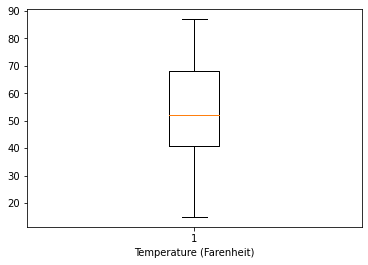

In [14]:
# Check for outliers
df = sdf_data_trunc.toPandas()
plt.boxplot(df['temp'])
plt.xlabel('Temperature (Farenheit)')
plt.show()

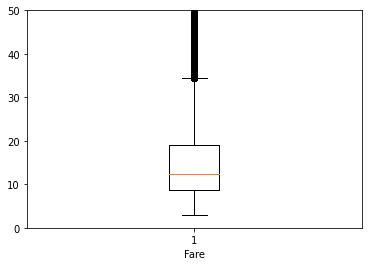

In [17]:
df = sdf_data_trunc.toPandas()
plt.boxplot(df['fare'])
plt.xlabel('Fare')
plt.ylim([0,50])
plt.show()

We see that there are lots of outliers so we will remove all of them outside the inter-quantile range

In [20]:
upper_q = sdf_data_trunc.approxQuantile('fare', [0.75], 0)
upper_q

[19.05]

In [22]:
sdf_data_trunc.filter(F.col('fare') < 20).count()

462811

In [23]:
# We want to save the last two month of data for prediction from models
predict_sdf = sdf_data_trunc.filter(F.col('Date') > '2022-02-28')
sdf_result = sdf_data_trunc.filter(F.col('Date') <= '2022-02-28')

In [24]:
predict_sdf.write.mode('overwrite').parquet('../data/curated/result_predict')
sdf_result.write.mode('overwrite').parquet('../data/curated/result_data')